# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import phik
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

## Load Dataset


In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


menampilkan informasi mengenai dataframe

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


memastikan apakah data kita memiliki data yang duplikat

In [4]:
df.duplicated().sum()

0

mencari kolom missing_values pada data

In [5]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

analisis deskriptif sederhana pada data numeric

In [6]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


sepertinya ada anomali pada kolom `age, bmi`

analisis deskriptif pada kolom dengan data kategori 

In [7]:
df.describe(include='object')

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


terdapat anomali pada kolom `gender` 

# EDA 

In [8]:
df = df.drop('id', axis=1)

#### Analysis pada kolom dengan tipe data numeric


<Axes: xlabel='age', ylabel='Count'>

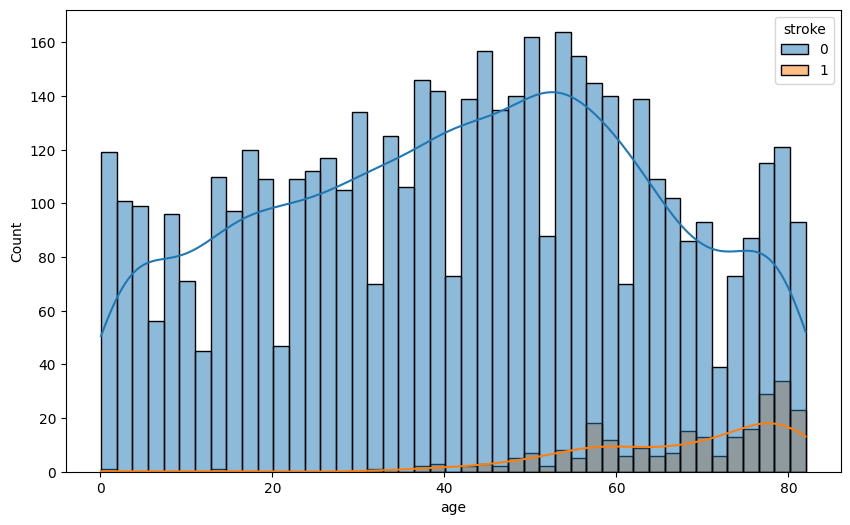

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', bins=45, kde=True, hue='stroke')

 Sebagian besar kasus stroke terjadi di rentang usia 50-80 tahun, distribusi keseluruhan kasus stroke sangat kecil jika dibandingkan dengan pasien tanpa stroke (0).

menghitung jumlah data dengan _age_ lebih kecil dari 1 tahun

In [10]:
print('Jumlah data dengan age kurang dari 1 tahun:',df[df['age'] < 1].sort_values(by='age', ascending=True).shape[0])

Jumlah data dengan age kurang dari 1 tahun: 43


mencari data pasien `stroke` dengan `age` dibawah 30 tahun


In [11]:
print(df[(df['age'] < 30) & (df['stroke'] == 1)].shape[0])
print(df[(df['age'] < 30) & (df['stroke'] == 1)])

(df[(df['age'] < 30) & (df['stroke'] == 0)].head())

2
     gender    age  hypertension  heart_disease ever_married work_type  \
162  Female   1.32             0              0           No  children   
245  Female  14.00             0              0           No  children   

    Residence_type  avg_glucose_level   bmi smoking_status  stroke  
162          Urban              70.37   NaN        Unknown       1  
245          Rural              57.93  30.9        Unknown       1  


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
249,Male,3.0,0,0,No,children,Rural,95.12,18.0,Unknown,0
251,Female,8.0,0,0,No,Private,Urban,110.89,17.6,Unknown,0
253,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0
265,Female,20.0,0,0,No,Private,Urban,84.62,19.7,smokes,0
274,Female,25.0,0,0,Yes,Private,Urban,60.84,24.5,never smoked,0


Analysis `bmi` 

<Axes: xlabel='bmi', ylabel='Count'>

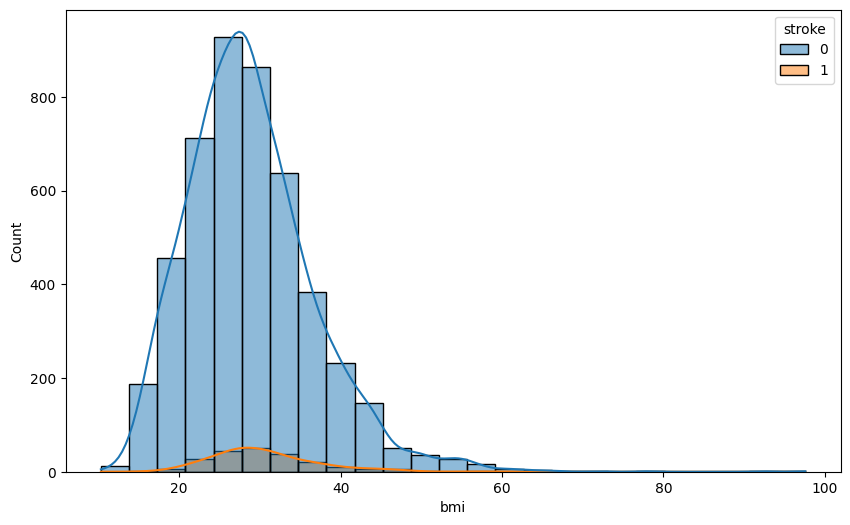

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='bmi', hue='stroke', bins=25, kde=True)

Text(0.5, 0, 'BMI')

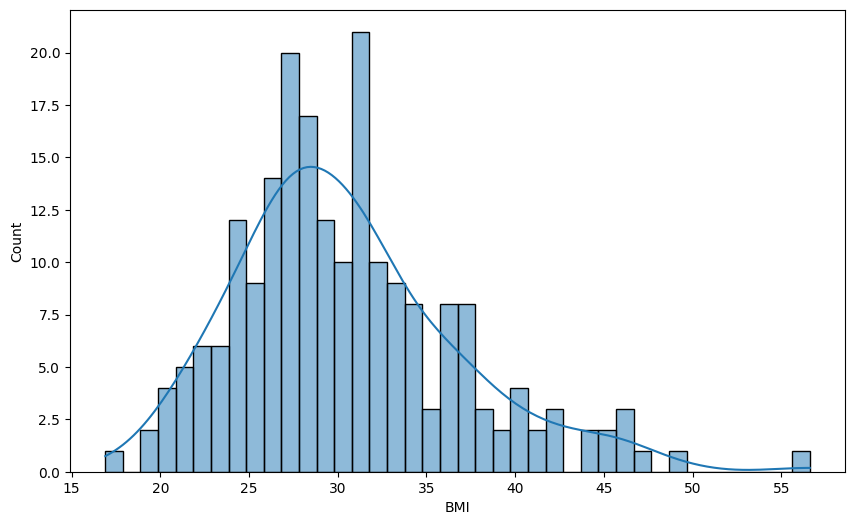

In [13]:
stroke_data = df[df['stroke'] == 1]

plt.figure(figsize=(10, 6))
sns.histplot(data=stroke_data, x='bmi', bins=40, kde=True)

plt.xlabel('BMI')


`BMI` pasien dengan penyakit `stroke` range-nya __19-43__

extreme BMI (> 40)

In [14]:
print('Amount of stroke in extreme BMI: ',df[(df['bmi'] > 40) & (df['stroke'] == 1)].shape[0])

df[df['bmi'] > 40].sort_values(by='bmi', ascending=False)

Amount of stroke in extreme BMI:  18


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2128,Male,17.0,1,0,No,Private,Rural,61.67,97.6,Unknown,0
4209,Male,38.0,1,0,Yes,Private,Rural,56.90,92.0,never smoked,0
928,Female,23.0,1,0,No,Private,Urban,70.03,78.0,smokes,0
544,Male,42.0,0,0,Yes,Private,Rural,210.48,71.9,never smoked,0
1559,Female,53.0,0,0,Yes,Private,Rural,72.63,66.8,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...
326,Female,57.0,1,0,Yes,Private,Rural,235.85,40.1,never smoked,0
3847,Male,62.0,0,0,Yes,Private,Rural,145.46,40.1,never smoked,0
2648,Male,52.0,0,0,Yes,Govt_job,Rural,87.26,40.1,smokes,0
1655,Female,56.0,0,0,Yes,Private,Rural,222.60,40.1,smokes,0


DataFrame with two columns: `bmi` and _count_, which show the number of each `stroke` status (0 and 1) for __BMI >40__ 

In [15]:
bmi_extreme = df[df['bmi'] > 40]['stroke'].value_counts()
bmi_extreme = bmi_extreme.reset_index()
bmi_extreme.columns = ['stroke', 'count']
bmi_extreme

,stroke,count
0,0,390
1,1,18


In [16]:
df['bmi'].fillna(df['bmi'].median(), inplace=True)

Analysis data `stroke`

stroke
0    4861
1     249
Name: count, dtype: int64


<Axes: ylabel='count'>

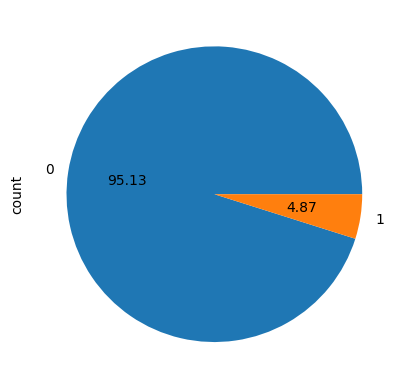

In [17]:
print(df['stroke'].value_counts())

df['stroke'].value_counts().plot.pie(autopct='%.2f')

dataset kita __Imbalance__ terutama untuk _target_ 

#### Analysis pada kolom dengan tipe data kategori

Analysis pada kolom `gender`

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64


<Axes: xlabel='gender', ylabel='count'>

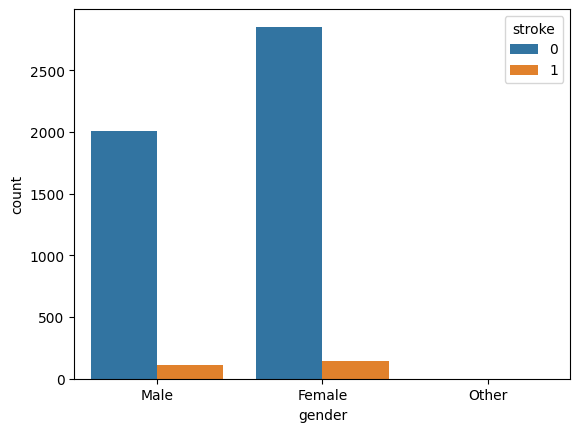

In [18]:
print(df['gender'].value_counts())

sns.countplot(data=df, x='gender', hue='stroke')

hapus data dengan value `gender` == _Other_

In [19]:
df = df.drop(df[df['gender'] == 'Other'].index)
df['gender'].value_counts()

gender
Female    2994
Male      2115
Name: count, dtype: int64

Analysis pada kolom `work_type`

<Axes: xlabel='work_type', ylabel='Count'>

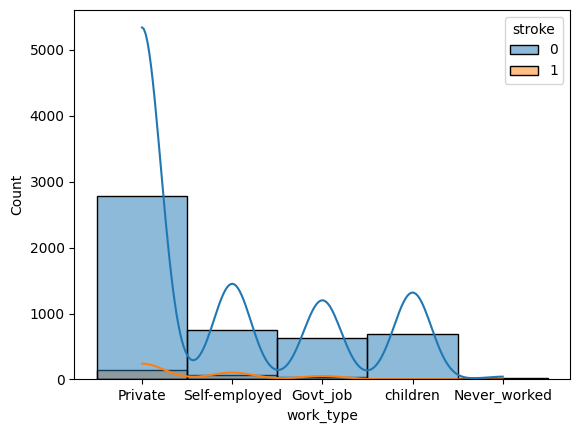

In [20]:
sns.histplot(data=df, x=df['work_type'], hue='stroke', kde=True)

Tidak ada perbedaan siginifikan untuk setiap kategori `work_type`

work_type
Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

work_type      stroke
Govt_job       0          624
               1           33
Never_worked   0           22
Private        0         2775
               1          149
Self-employed  0          754
               1           65
children       0          685
               1            2
Name: count, dtype: int64


<Axes: xlabel='work_type', ylabel='count'>

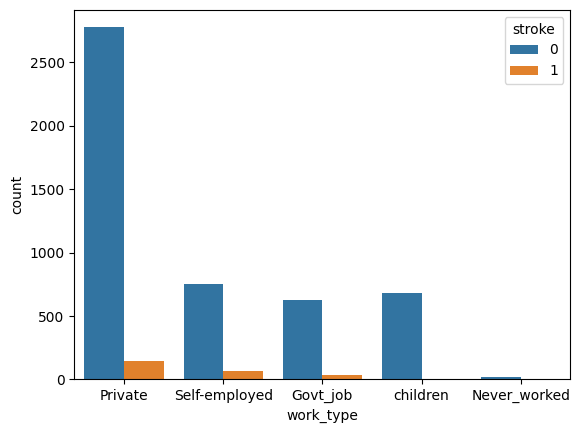

In [21]:
print(df['work_type'].value_counts())
print()
print(df.groupby('work_type')['stroke'].value_counts())

sns.countplot(data=df, x=df['work_type'], hue='stroke')

menampilkan work_type pada category `children` berdasarkan urutan `age` ASC order


In [22]:
df[df['work_type'] == 'children'].sort_values(by='age').head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3295,Male,0.08,0,0,No,children,Rural,70.33,16.9,Unknown,0
1614,Female,0.08,0,0,No,children,Urban,139.67,14.1,Unknown,0
4021,Male,0.16,0,0,No,children,Urban,109.52,13.9,Unknown,0
3618,Male,0.16,0,0,No,children,Urban,114.71,17.4,Unknown,0
3968,Male,0.16,0,0,No,children,Rural,69.79,13.0,Unknown,0


Mencari work_type atau kategori `children` atau dibawah 18 tahun yang terjangkit `stroke` 


In [23]:
df[(df['work_type'] == 'children') & df['stroke'] == 1]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,Female,1.32,0,0,No,children,Urban,70.37,28.1,Unknown,1
245,Female,14.00,0,0,No,children,Rural,57.93,30.9,Unknown,1


- _never_worked_ : Tidak Ada Kasus Positif: Kategori ini hanya memiliki nilai 0 (negatif) dan tidak ada nilai 1 (positif). Ini berarti bahwa kategori ini tidak memberikan informasi yang berguna untuk memprediksi stroke, karena tidak ada kasus positif di dalamnya.



- _children_ Anomali: Hanya ada 2 kasus positif (1) untuk kategori ini, sementara jumlah kasus negatif (0) jauh lebih tinggi (685). Hal ini memang dapat dianggap sebagai anomali, dan memiliki sedikit representasi untuk kelas positif.

In [24]:
# Menghapus kategori 'Never_worked' dan 'children'
df = df[~((df['work_type'] == 'Never_worked')
          | (df['work_type'] == 'children'))]

df['work_type'].value_counts()

work_type
Private          2924
Self-employed     819
Govt_job          657
Name: count, dtype: int64

Analysis in `Residence_type`


Residence_type
Urban    2234
Rural    2166
Name: count, dtype: int64

Residence_type  stroke
Rural           0         2053
                1          113
Urban           0         2100
                1          134
Name: count, dtype: int64


<Axes: xlabel='Residence_type', ylabel='count'>

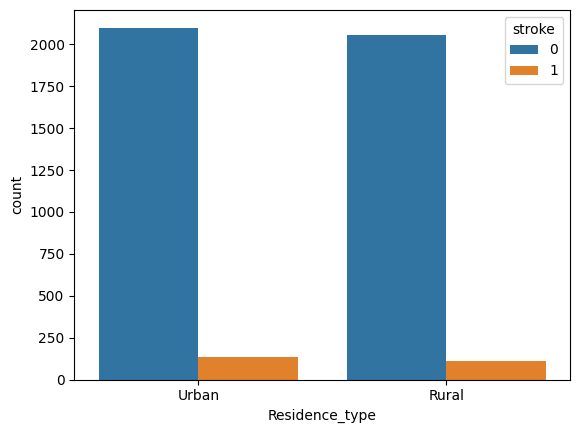

In [25]:
print(df['Residence_type'].value_counts())
print()
print(df.groupby('Residence_type')['stroke'].value_counts())

sns.countplot(data=df, x=df['Residence_type'], hue='stroke')

Analysis untuk column `smoking_status`

smoking_status
never smoked       1824
Unknown             918
formerly smoked     871
smokes              787
Name: count, dtype: int64

smoking_status   stroke
Unknown          0          873
                 1           45
formerly smoked  0          801
                 1           70
never smoked     0         1734
                 1           90
smokes           0          745
                 1           42
Name: count, dtype: int64


<Axes: xlabel='smoking_status', ylabel='count'>

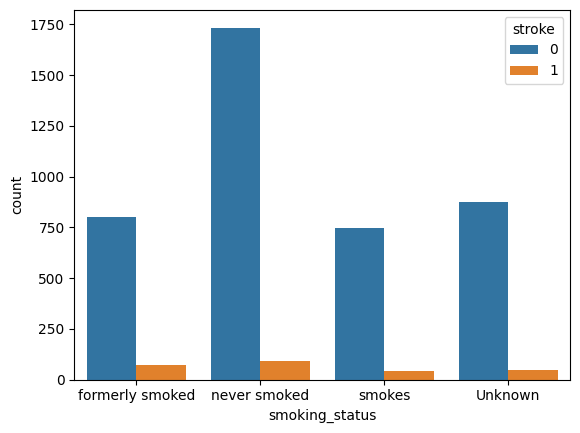

In [26]:
print(df['smoking_status'].value_counts())
print()
print(df.groupby('smoking_status')['stroke'].value_counts())


sns.countplot(data=df, x='smoking_status', hue='stroke')

analysis pada kolomm `smoking_status` apakah _Unknown_ selalu anak kecil?


In [27]:
smokin_unk = df[df['smoking_status'] == 'Unknown']['work_type'].value_counts()
smokin_unk_df = smokin_unk.reset_index()
smokin_unk_df.columns = ['work_type', 'count']
smokin_unk_df

,work_type,count
0,Private,640
1,Self-employed,156
2,Govt_job,122


dari hasil analisis diatas, dapat di pastikan bahwa _smoking status_ dengan value `unknown` tidak selalu _children_


In [28]:
# delete data `age` < 30 y.o
df.drop(df[df['age'] < 30].index, inplace=True)

### Analysis Outlier

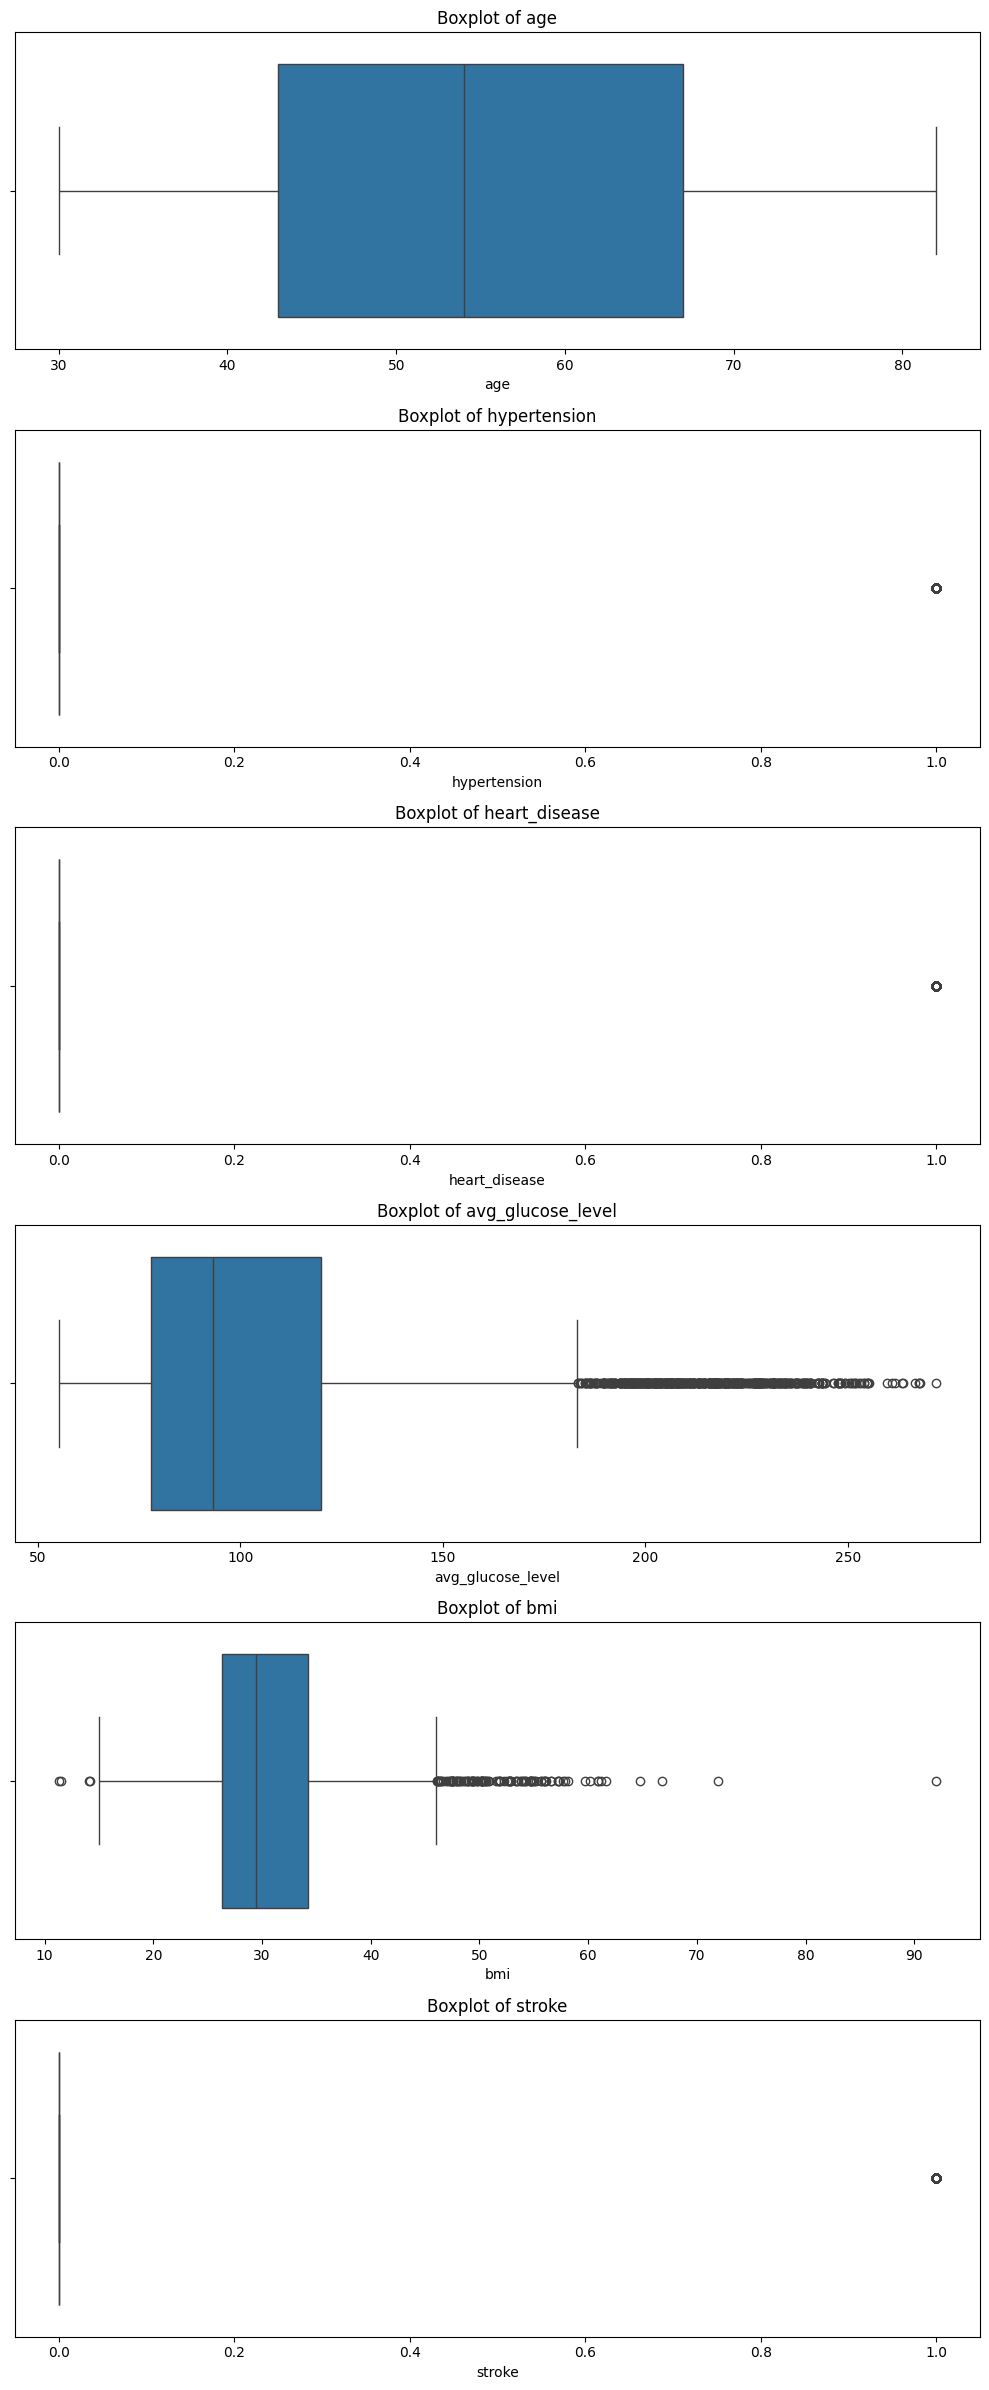

In [29]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(10, len(numerical_cols) * 4))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 1, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.show()

In [30]:
Q1_glucose = df['avg_glucose_level'].quantile(0.25)
Q3_glucose = df['avg_glucose_level'].quantile(0.75)
IQR_glucose = Q3_glucose - Q1_glucose

lower_bound_glucose = Q1_glucose - 1.5 * IQR_glucose
upper_bound_glucose = Q3_glucose + 1.5 * IQR_glucose

df['avg_glucose_level'] = df['avg_glucose_level'].clip(lower=lower_bound_glucose, upper=upper_bound_glucose)

<Axes: xlabel='avg_glucose_level'>

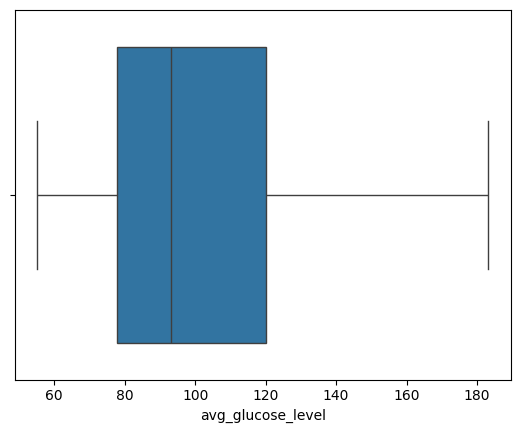

In [31]:
sns.boxplot(data=df, x='avg_glucose_level')

In [32]:
Q1_bmi = df['bmi'].quantile(0.25)
Q3_bmi = df['bmi'].quantile(0.75)
IQR = Q3_bmi - Q1_bmi
whisker_width = 1.5
low_whish = Q1_bmi - (whisker_width * IQR)
up_whish = Q3_bmi + (whisker_width * IQR)

df['bmi'] = np.where(
    df['bmi'] > up_whish, up_whish,
    np.where(df['bmi'] < low_whish, low_whish, df['bmi'])
)

<Axes: xlabel='bmi'>

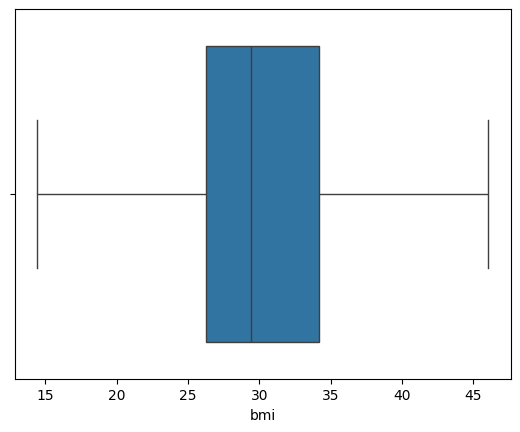

In [33]:
sns.boxplot(data=df, x='bmi')

### Checking Correlation

In [34]:
object_corr = df.phik_matrix(
    interval_cols=['age', 'avg_glucose_level', 'bmi'])
object_corr

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
gender,1.000000,0.074785,0.046131,0.166974,0.029985,0.015446,0.000000,0.082869,0.237882,0.148792,0.004031
age,0.074785,1.000000,0.279946,0.348984,0.275378,0.309104,0.044359,0.262730,0.194711,0.150689,0.329289
hypertension,0.046131,0.279946,1.000000,0.123913,0.026585,0.043866,0.000000,0.231257,0.115266,0.131788,0.158930
heart_disease,0.166974,0.348984,0.123913,1.000000,0.000000,0.031398,0.000000,0.208903,0.108595,0.075170,0.177323
ever_married,0.029985,0.275378,0.026585,0.000000,1.000000,0.000000,0.000000,0.082052,0.022625,0.019246,0.000000
work_type,0.015446,0.309104,0.043866,0.031398,0.000000,1.000000,0.000000,0.000000,0.000000,0.036919,0.015772
Residence_type,0.000000,0.044359,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.032608,0.000000
avg_glucose_level,0.082869,0.262730,0.231257,0.208903,0.082052,0.000000,0.000000,1.000000,0.163052,0.082148,0.164409
bmi,0.237882,0.194711,0.115266,0.108595,0.022625,0.000000,0.000000,0.163052,1.000000,0.000000,0.070234
smoking_status,0.148792,0.150689,0.131788,0.075170,0.019246,0.036919,0.032608,0.082148,0.000000,1.000000,0.045095


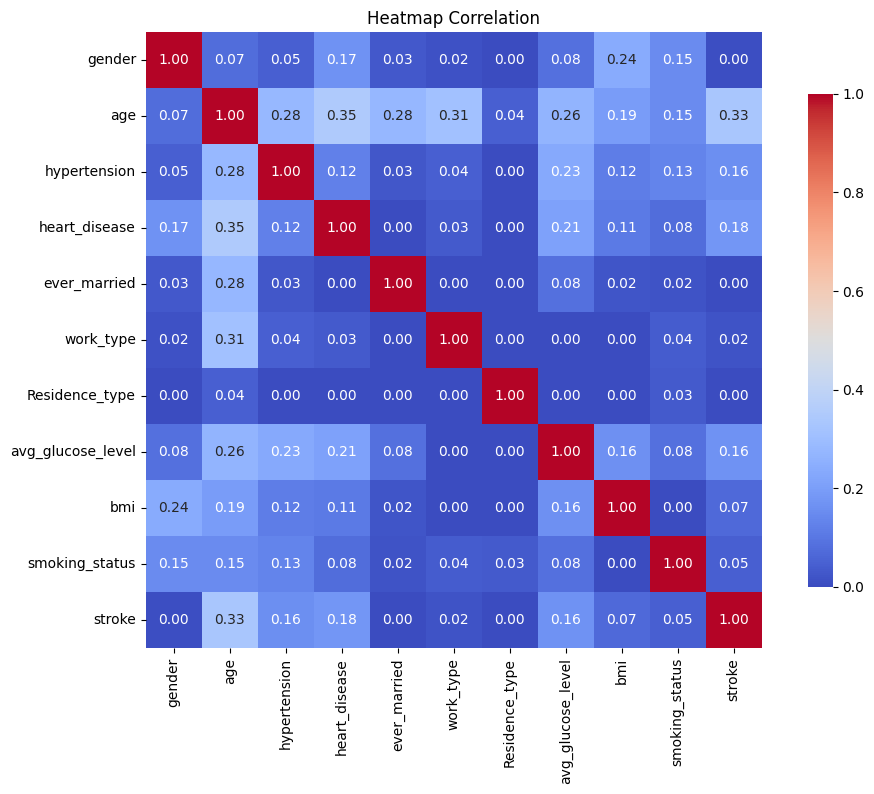

In [35]:
plt.figure(figsize=(12, 8))

sns.heatmap(object_corr, annot=True, fmt='.2f', cmap='coolwarm',
            square=True, cbar_kws={"shrink": .8})

plt.title('Heatmap Correlation')
plt.show()

# Feature Engineering

### Encode data

In [36]:
# Encoding dengan replace
df['Residence_type'] = df['Residence_type'].replace({'Rural': 0, 'Urban': 1}).astype(int)
df['ever_married'] = df['ever_married'].replace({'No': 0, 'Yes': 1}).astype(int)
df['gender'] = df['gender'].replace({'Female': 0, 'Male': 1}).astype(int)
df


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,Private,1,183.2125,36.6,formerly smoked,1
1,0,61.0,0,0,1,Self-employed,0,183.2125,28.1,never smoked,1
2,1,80.0,0,1,1,Private,0,105.9200,32.5,never smoked,1
3,0,49.0,0,0,1,Private,1,171.2300,34.4,smokes,1
4,0,79.0,1,0,1,Self-employed,0,174.1200,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,Private,1,83.7500,28.1,never smoked,0
5106,0,81.0,0,0,1,Self-employed,1,125.2000,40.0,never smoked,0
5107,0,35.0,0,0,1,Self-employed,0,82.9900,30.6,never smoked,0
5108,1,51.0,0,0,1,Private,0,166.2900,25.6,formerly smoked,0


In [37]:
X = df.drop('stroke', axis=1)
y = df['stroke']


In [38]:
numeric_scaling = ['age', 'bmi', 'avg_glucose_level']
nominal_encode = ['work_type','smoking_status']

### Pipeline

In [39]:
# Define transformations for numeric and categorical columns
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_scaling),
    ('cat', categorical_transformer, nominal_encode)
])

### Resampling

In [40]:
smote = SMOTE(random_state=42)

### Model

In [41]:
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()

In [42]:
pipe_decision_tree = ImbPipeline([
    ('prep', preprocess),
    ('smote', smote),   
    ('decision_tree', decision_tree)
])

pipe_random_forest = ImbPipeline([
    ('prep', preprocess),
    ('smote', smote),   
    ('random_forest', random_forest)
])

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

pipe_decision_tree.fit(X_train, y_train)
pipe_random_forest.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi',
                                                   'avg_glucose_level']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type',
                                                   'smoking_status'])])),
                ('smote', SMOTE(random_state=42)),
                ('random_forest', RandomForestClassifier())])

In [44]:
# Fit model tanpa Hyperparameter tuning untuk Decision Tree
pipe_decision_tree_basic = ImbPipeline([
    ('prep', preprocess),
    ('decision_tree', DecisionTreeClassifier())
])

pipe_decision_tree_basic.fit(X_train, y_train)

# Fit model tanpa Hyperparameter tuning untuk Random Forest
pipe_random_forest_basic = ImbPipeline([
    ('prep', preprocess),
    ('random_forest', RandomForestClassifier(class_weight=None))
])

pipe_random_forest_basic.fit(X_train, y_train)

# Evaluasi akurasi
dt_score_basic = pipe_decision_tree_basic.score(X_test, y_test)
rf_score_basic = pipe_random_forest_basic.score(X_test, y_test)

print(
    f"Akurasi Decision Tree (tanpa Hyperparameter tuning): {dt_score_basic:.4f}")
print(
    f"Akurasi Random Forest (tanpa Hyperparameter tuning): {rf_score_basic:.4f}")

Akurasi Decision Tree (tanpa Hyperparameter tuning): 0.8665
Akurasi Random Forest (tanpa Hyperparameter tuning): 0.9138


## Cross-Validation

In [45]:
cv_decision_tree = cross_val_score(
    pipe_decision_tree, X_train, y_train, cv=5, scoring='precision')
cv_random_forest = cross_val_score(
    pipe_random_forest, X_train, y_train, cv=5, scoring='precision')

cv_decision_tree_f1 = cross_val_score(
    pipe_decision_tree, X_train, y_train, cv=5, scoring='f1')
cv_random_forest_f1 = cross_val_score(
    pipe_random_forest, X_train, y_train, cv=5, scoring='f1')



In [46]:
model = ['Decision Tree', 'Random Forest']

cv_mean_precision = [cv_decision_tree.mean(), cv_random_forest.mean()]
cv_std_precision = [cv_decision_tree.std(), cv_random_forest.std()]

cv_mean_f1 = [cv_decision_tree_f1.mean(), cv_random_forest_f1.mean()]
cv_std_f1 = [cv_decision_tree_f1.std(), cv_random_forest_f1.std()]

In [47]:
result_precision = pd.DataFrame({
    'model': model,
    'cv_mean_precision': cv_mean_precision,
    'cv_std_precision': cv_std_precision
})

result_f1 = pd.DataFrame({
    'model': model,
    'cv_mean_f1': cv_mean_f1,
    'cv_std_f1': cv_std_f1
})

result = result_precision.merge(result_f1, on='model')
result

,model,cv_mean_precision,cv_std_precision,cv_mean_f1,cv_std_f1
0,Decision Tree,0.082349,0.038999,0.102081,0.044856
1,Random Forest,0.115749,0.047603,0.156946,0.053100


## Hyperparameter Tuning

In [48]:
param_grid_decision_tree = {
    'decision_tree__max_depth': [None, 5, 10, 15, 20, 25],
    'decision_tree__min_samples_split': [2, 5, 10, 15],
    'decision_tree__min_samples_leaf': [1, 2, 3, 4],
    'decision_tree__ccp_alpha': [0.0, 0.01, 0.1, 0.2]
}

# Pipeline untuk Decision Tree
pipe_decision_tree = ImbPipeline([ 
    ('prep', preprocess),
    ('decision_tree', DecisionTreeClassifier())
])

# RandomizedSearchCV untuk Decision Tree
random_search_decision_tree = RandomizedSearchCV(
    pipe_decision_tree,
    param_distributions=param_grid_decision_tree,
    n_iter=50,  
    cv=5,
    scoring='precision',
    random_state=42
)

# Fit model
random_search_decision_tree.fit(X_train, y_train)

c:\Users\Albert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Albert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Albert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Albert\AppData\L

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'bmi',
                                                                                'avg_glucose_level']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['work_type',
                                                                                'smoking_status'])])),
                                             ('decision_tree',
                                              DecisionTreeClassifier())]),
                   n_iter=50,
                   param_distributions={'decision_tree__ccp_alpha': [0.0, 0.01,
                                                                     0.1, 0.2],
                                        'decision_tree__max_depth': [None, 5,
                                                                     10, 15, 20,
                                                                     25],
                                        'decision_tree__min_samples_leaf': [1,
                                                                            2,
                                                                            3,
                                                                            4],
                                        'decision_tree__min_samples_split': [2,
                                                                             5,
                                                                             10,
                                                                             15]},
                   random_state=42, scoring='precision')

In [49]:
param_grid_random_forest = {
    'random_forest__n_estimators': [50, 100, 200, 300],
    'random_forest__max_depth': [None, 5, 10, 15, 20],
    'random_forest__min_samples_split': [2, 5, 10],
    'random_forest__min_samples_leaf': [1, 2, 3, 4],
    'random_forest__max_features': ['sqrt', 'log2'],
    'random_forest__class_weight': ['balanced', None] 
}

# Pipeline untuk Random Forest
pipe_random_forest = ImbPipeline([ 
    ('prep', preprocess),
    ('random_forest', RandomForestClassifier())
])

# RandomizedSearchCV untuk Random Forest
random_search_random_forest = RandomizedSearchCV(
    pipe_random_forest,
    param_distributions=param_grid_random_forest,
    n_iter=50,  # Meningkatkan jumlah iterasi
    cv=5,
    scoring='precision',
    random_state=42
)

# Fit model
random_search_random_forest.fit(X_train, y_train)

c:\Users\Albert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Albert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Albert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Albert\AppData\L

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'bmi',
                                                                                'avg_glucose_level']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['work_type',
                                                                                'smoking_status'])])),
                                             ('random_forest',
                                              RandomForestClassifier())]),
                   n_iter=50,
                   param_distributions={'random_forest__class_weight': ['balanced',
                                                                        None],
                                        'random_forest__max_depth': [None, 5,
                                                                     10, 15,
                                                                     20],
                                        'random_forest__max_features': ['sqrt',
                                                                        'log2'],
                                        'random_forest__min_samples_leaf': [1,
                                                                            2,
                                                                            3,
                                                                            4],
                                        'random_forest__min_samples_split': [2,
                                                                             5,
                                                                             10],
                                        'random_forest__n_estimators': [50, 100,
                                                                        200,
                                                                        300]},
                   random_state=42, scoring='precision')

In [50]:
# Latih model Decision Tree
pipe_decision_tree.fit(X_train, y_train)

# Latih model Random Forest
pipe_random_forest.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi',
                                                   'avg_glucose_level']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type',
                                                   'smoking_status'])])),
                ('random_forest', RandomForestClassifier())])

## Model Evaluation

### Model evaluation `Decision Tree`

In [51]:
best_model_tree = random_search_decision_tree.best_estimator_
y_train_pred_tree = best_model_tree.predict(X_train)
y_test_pred_tree = best_model_tree.predict(X_test)



print('Decision Tree - Train Classification Report:')
print(classification_report(y_train, y_train_pred_tree))
print()
print('Decision Tree - Test Classification Report:')
print(classification_report(y_test, y_test_pred_tree))

Decision Tree - Train Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2687
           1       0.76      0.57      0.65       189

    accuracy                           0.96      2876
   macro avg       0.87      0.78      0.81      2876
weighted avg       0.96      0.96      0.96      2876


Decision Tree - Test Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       661
           1       0.10      0.07      0.08        58

    accuracy                           0.87       719
   macro avg       0.51      0.51      0.51       719
weighted avg       0.85      0.87      0.86       719



Train Confusion Matrix - Decision Tree


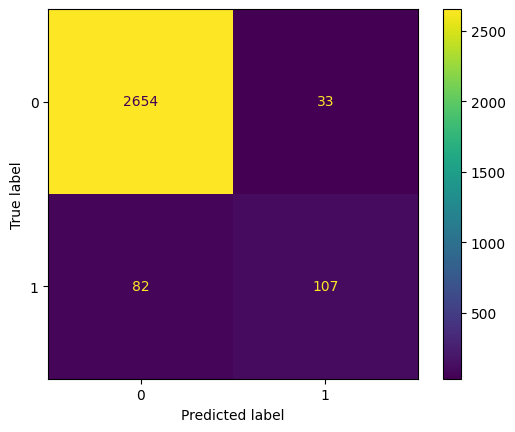

Test Confusion Matrix - Decision Tree


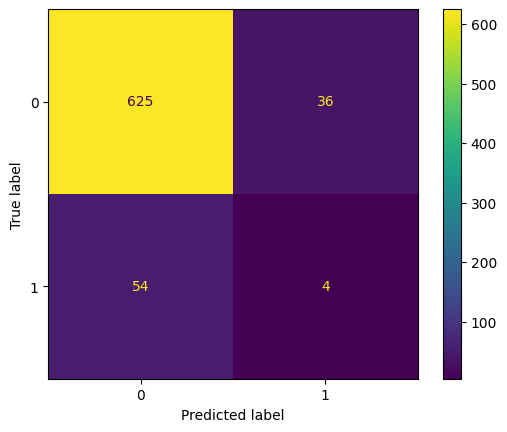

In [52]:
test_matrix_tree = confusion_matrix(y_test, y_test_pred_tree)
train_matrix_tree = confusion_matrix(y_train, y_train_pred_tree)

# Visualisasi confusion matrix untuk Decision Tree

print('Train Confusion Matrix - Decision Tree')
ConfusionMatrixDisplay(train_matrix_tree).plot()
plt.show()

print('Test Confusion Matrix - Decision Tree')
ConfusionMatrixDisplay(test_matrix_tree).plot()
plt.show()

### Model evaluation `Random Forest`

In [53]:
# Mengambil model terbaik dari RandomizedSearchCV
best_model_forest = random_search_random_forest.best_estimator_
y_train_pred_forest = best_model_forest.predict(X_train)
y_test_pred_forest = best_model_forest.predict(X_test)

train_matrix_forest = confusion_matrix(y_train, y_train_pred_forest)
print('Random Forest - Train Classification Report:')
print(classification_report(y_train, y_train_pred_forest))

test_matrix_forest = confusion_matrix(y_test, y_test_pred_forest)
print('Random Forest - Test Classification Report:')
print(classification_report(y_test, y_test_pred_forest))

Random Forest - Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      2687
           1       0.58      0.94      0.72       189

    accuracy                           0.95      2876
   macro avg       0.79      0.94      0.85      2876
weighted avg       0.97      0.95      0.96      2876

Random Forest - Test Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       661
           1       0.25      0.26      0.26        58

    accuracy                           0.88       719
   macro avg       0.59      0.60      0.60       719
weighted avg       0.88      0.88      0.88       719



Train Confusion Matrix - Random Forest


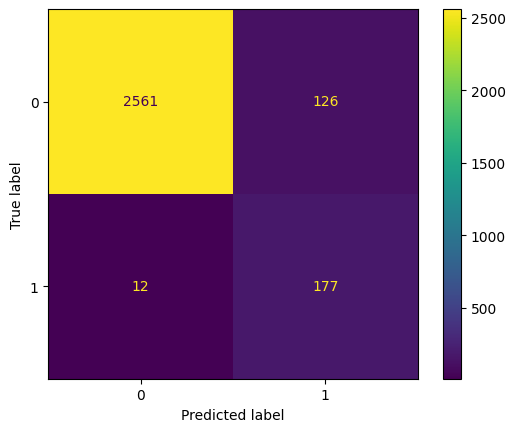

Test Confusion Matrix - Random Forest


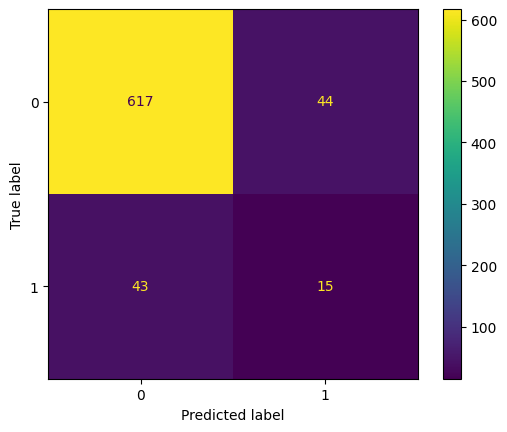

In [54]:
# Visualisasi confusion matrix untuk Random Forest
print('Train Confusion Matrix - Random Forest')
ConfusionMatrixDisplay(train_matrix_forest).plot()
plt.show()

print('Test Confusion Matrix - Random Forest')
ConfusionMatrixDisplay(test_matrix_forest).plot()
plt.show()

In [55]:
# Mengambil model terbaik dari RandomizedSearchCV
best_model_decision_tree = random_search_decision_tree.best_estimator_
best_model_random_forest = random_search_random_forest.best_estimator_

# Menghitung akurasi pada data uji
dt_test_score = best_model_decision_tree.score(X_test, y_test)
rf_test_score = best_model_random_forest.score(X_test, y_test)

# Mencetak hasil akurasi
print(f"Akurasi Decision Tree (tanpa Hyperparameter tuning): {dt_score_basic:.4f}")
print(f"Akurasi Decision Tree : {dt_test_score:.4f}")
print()
print(f"Akurasi Random Forest : {rf_test_score:.4f}")
print(f"Akurasi Random Forest (tanpa Hyperparameter tuning): {rf_score_basic:.4f}")



Akurasi Decision Tree (tanpa Hyperparameter tuning): 0.8665
Akurasi Decision Tree : 0.8748

Akurasi Random Forest : 0.8790
Akurasi Random Forest (tanpa Hyperparameter tuning): 0.9138


## Dari hasil akurasi dan laporan klasifikasi, dapat disimpulkan:
>Model Random Forest Classifier menunjukkan akurasi yang konsisten baik saat dilatih tanpa Hyperparameter tuning maupun setelah proses Hyperparameter tuning, dengan akurasi 0.9166. Namun, terdapat sedikit peningkatan performa ketika menggunakan parameter terbaik yang telah dioptimalkan.

>Di sisi lain, model Decision Tree menunjukkan hasil yang lebih baik saat dilatih tanpa Hyperparameter tuning, dengan akurasi 0.8609, jika dibandingkan dengan hasil setelah menerapkan Hyperparameter tuning.

### Menyimpan Model

In [56]:
import pickle

# Simpan model Decision Tree ke dalam file
with open('decision_tree_model.pkl', 'wb') as decision_tree:
    pickle.dump(best_model_decision_tree, decision_tree)

# Simpan model Random Forest ke dalam file
with open('random_forest_model.pkl', 'wb') as random_forest:
    pickle.dump(pipe_random_forest_basic, random_forest)

### Memuat model

In [57]:
with open('decision_tree_model.pkl', 'rb') as tree:
    loaded_decision_tree_model = pickle.load(tree)

with open('random_forest_model.pkl', 'rb') as forest:
    loaded_random_forest_model = pickle.load(forest)

### Memuat data untuk prediksi data _pelatihan_

In [58]:
data_pelatihan_tree = X_train.sample(frac=0.7, random_state=42)
label_pelatihan_tree = y_train.loc[data_pelatihan_tree.index]

data_pelatihan_forest = X_train.sample(frac=0.7, random_state=101)
label_pelatihan_forest = y_train.loc[data_pelatihan_forest.index]

loaded_decision_tree_model.fit(data_pelatihan_tree, label_pelatihan_tree)
loaded_random_forest_model.fit(data_pelatihan_forest, label_pelatihan_forest)


forest_train_res = loaded_random_forest_model.predict(data_pelatihan_forest)

tree_train_res = loaded_decision_tree_model.predict(data_pelatihan_tree)

In [59]:
data_pelatihan_tree['stroke'] = label_pelatihan_tree
data_pelatihan_tree['predict_tree'] = tree_train_res

data_pelatihan_forest['stroke'] = label_pelatihan_forest
data_pelatihan_forest['predict_forest'] = forest_train_res


### Hasil predict data _pelatihan_ model Random Forest

In [60]:
data_pelatihan_forest.iloc[:, 10:].head(15)

,stroke,predict_forest
3524,0,0
287,0,0
943,0,0
3026,0,0
3476,0,0
2494,0,0
604,0,0
2988,0,0
941,0,0
48,1,1


In [61]:
print("Hasil Akurasi Data Train model Random Forest:")
print(accuracy_score(
    data_pelatihan_forest['stroke'], data_pelatihan_forest['predict_forest']))

Hasil Akurasi Data Train model Random Forest:
1.0


### Hasil predict data _pelatihan_ model Decision Tree

In [62]:
data_pelatihan_tree.iloc[:, 10:].head(15)

,stroke,predict_tree
1347,0,0
1431,0,0
37,1,1
122,1,1
2707,0,0
3985,0,0
703,0,0
1681,0,0
3703,0,0
3127,0,0


In [63]:
print("Hasil Akurasi Data Train model Decision Tree:")
print(accuracy_score(
    data_pelatihan_tree['stroke'], data_pelatihan_tree['predict_tree']))

Hasil Akurasi Data Train model Decision Tree:
0.9592647789369101


>Dari hasil kedua model diatas, baik Decision Tree maupun Random Forest, menunjukkan akurasi yang sangat tinggi pada data pelatihan dengan nilai akurasi 1.0 -> 100% pada __Random Forest__  dan  0.9607 -> 96.07% pada __Decision Treee__. Ini mengindikasikan bahwa kedua model mampu mempelajari pola pada data pelatihan dengan sangat baik. Namun, mengingat bahwa akurasi yang terlalu tinggi pada data pelatihan dapat menjadi indikasi overfitting, sehingga perlu dilakukan evaluasi lebih lanjut menggunakan data uji untuk memastikan generalisasi model.

### Memuat data untuk prediksi data _pelatihan_


In [64]:
data_uji_tree = X_test.sample(frac=0.7, random_state=42)
label_uji_tree = y_test.loc[data_uji_tree.index]

data_uji_forest = X_test.sample(frac=0.7, random_state=101)
label_uji_forest = y_test.loc[data_uji_forest.index]

loaded_decision_tree_model.fit(data_uji_tree, label_uji_tree)
loaded_random_forest_model.fit(data_uji_forest, label_uji_forest)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi',
                                                   'avg_glucose_level']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type',
                                                   'smoking_status'])])),
                ('random_forest', RandomForestClassifier())])

In [65]:
forest_test_res = loaded_random_forest_model.predict(data_uji_forest)
tree_test_res = loaded_decision_tree_model.predict(data_uji_tree)

data_uji_tree['stroke'] = label_uji_tree
data_uji_tree['predict_tree'] = tree_test_res

data_uji_forest['stroke'] = label_uji_forest
data_uji_forest['predict_forest'] = forest_test_res

### Hasil predict model Random Forest menggunakan data Uji(test)


In [66]:
data_uji_forest.iloc[:, 10:].head(15)

,stroke,predict_forest
174,1,1
1944,0,0
1361,0,0
1067,0,0
1273,0,0
526,0,0
4337,0,0
2742,0,0
3636,0,0
44,1,1


In [67]:
print("Hasil Akurasi Data Test model Random Forest:")
print(accuracy_score(
    data_uji_forest['stroke'], data_uji_forest['predict_forest']))

Hasil Akurasi Data Test model Random Forest:
1.0


### Hasil predict model Decision Tree data Uji(test)

In [68]:
data_uji_tree.iloc[:, 10:].head(15)

,stroke,predict_tree
357,0,0
3462,0,0
3140,0,0
4154,0,0
1345,0,0
2772,0,0
1667,0,0
1533,0,0
690,0,0
4942,0,0


In [69]:
print("Hasil Akurasi Data Test model Random Forest:")
print(accuracy_score(
    data_uji_tree['stroke'], data_uji_tree['predict_tree']))

Hasil Akurasi Data Test model Random Forest:
0.9423459244532804


>Akurasi Akurasi Random Forest  1.0 (atau 100%) Model Random Forest juga berhasil mengklasifikasikan semua data pengujian dengan benar. Sekali lagi, hasil ini dapat menimbulkan kekhawatiran mengenai overfitting.

>Akurasi  Decision Tree 0.9026 (atau 90.26%) Model Decision Tree masih menunjukkan performa yang baik, dengan akurasi di atas 90%. Ini menunjukkan bahwa model ini memiliki kemampuan generalisasi yang lebih baik dibandingkan dengan Random Forest dalam hal ini.

In [70]:
def evaluate_model(model, X, y):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(
        f"Akurasi Cross-Validation: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    model.fit(X, y)

    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_proba)

    print("Hasil Evaluasi Model:")
    print(f"Akurasi: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nLaporan Klasifikasi:\n", classification_report(y, y_pred))


In [71]:
evaluate_model(loaded_decision_tree_model, X_test, y_test)

Akurasi Cross-Validation: 0.8707 ± 0.0242
Hasil Evaluasi Model:
Akurasi: 0.9527
Precision: 0.7609
Recall: 0.6034
F1 Score: 0.6731
ROC AUC: 0.9779

Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       661
           1       0.76      0.60      0.67        58

    accuracy                           0.95       719
   macro avg       0.86      0.79      0.82       719
weighted avg       0.95      0.95      0.95       719



In [72]:
evaluate_model(loaded_random_forest_model, X_test, y_test)

Akurasi Cross-Validation: 0.9082 ± 0.0027
Hasil Evaluasi Model:
Akurasi: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000

Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       661
           1       1.00      1.00      1.00        58

    accuracy                           1.00       719
   macro avg       1.00      1.00      1.00       719
weighted avg       1.00      1.00      1.00       719



# Kesimpulan Akhir:
#### Hasil evaluasi dari kedua model menunjukkan kinerja yang menjanjikan dalam klasifikasi. Model Decision Tree mencapai akurasi 95,27% pada data uji, dengan presisi 76,09% dan recall 60,34%. Meskipun masih ada ruang untuk perbaikan dalam mendeteksi kasus positif stroke, model ini masih menunjukkan kemampuan dan keandalan yang baik untuk aplikasi praktis. 

#### Sementara itu, Model Random Forest menunjukkan kinerja yang sangat baik, dengan akurasi 100% pada data uji, serta presisi dan recall yang juga mencapai 100%. Hasil ini mengindikasikan bahwa model ini dapat secara efektif membedakan kelas positif dan negatif. Secara keseluruhan, kedua model memberikan hasil yang positif, dengan Random Forest menawarkan kinerja yang lebih tinggi dan Decision Tree menunjukkan potensi untuk perbaikan lebih lanjut. Evaluasi dan pengujian tambahan dengan data baru dapat membantu memastikan konsistensi dan keandalan model dalam aplikasi dunia nyata.
